## Clustering - Data Science Portfolio - Maximilian Koch

**Dataset**: Land mine classification<br>
**Target variable**: Predicting the type of land mine<br>
**Features**: Sensor data<br>
**Techniques applied**: KMeans, Agglomerative Clustering, DBSCAN <br>


I chose this dataset on different types of land mines:
https://archive.ics.uci.edu/dataset/763/land+mines-1

### Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from collections import Counter

In [2]:
custom_data_path = "sem4_portfolio_8_data_custom.csv"
custom_df = pd.read_csv(custom_data_path)

In [3]:
custom_df['M'] -= 1 #unlike the dataset, the clustering algorithms start counting at 0, makes comparision easier

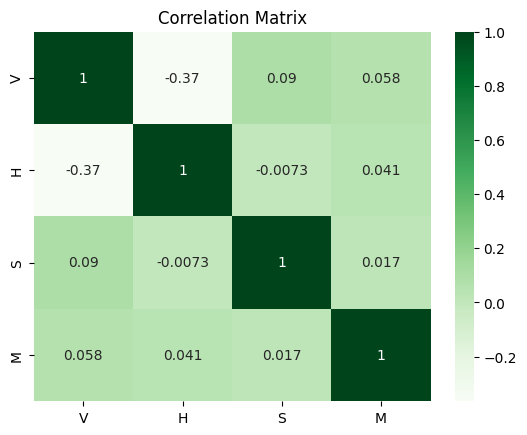

In [4]:
correlations = custom_df.corr('spearman')
sns.heatmap(correlations, annot=True, cmap='Greens')
plt.title('Correlation Matrix')
plt.show()

### Clustering

Since the input features are on different scales (0 to 10, 0 to 20, 1 to 6) scaling makes sense and is needed for the clustering algorithms!

In [5]:
X, y = custom_df[['V','H','S']],custom_df['M']
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X)

Hyperparameter optimisation for KMeans, Agglomerative Clustering, DBSCAN.
Ideally, n_clusters should return 5!

In [6]:
from sklearn.model_selection import GridSearchCV

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1 #one label only

cluster_models = {'KMeans':KMeans(n_init=10, random_state=0), #KMeans was unstable, so setting a random state
                  'Agglomerative':AgglomerativeClustering(),
                  'DBSCAN':DBSCAN()}

param_grids = {'KMeans': {'n_clusters': range(3,10)},
               'Agglomerative': {'n_clusters': range(3,10),
                                'linkage': ['ward', 'average', 'complete', 'single']}, #all linkage criterions available
                'DBSCAN': {'eps': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                           'min_samples': range(3,30)}}

optimized_models = {}

for name, model in cluster_models.items():
    print('---- Optimising',name,'----')
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer, cv=2) 
    grid_search.fit(X_scaled)
    optimized_models[name] = grid_search.best_estimator_

    print('Best parameters for',name,':',grid_search.best_params_)
    print('Best silhouette score for',name,':',grid_search.best_score_)
    

---- Optimising KMeans ----
Best parameters for KMeans : {'n_clusters': 5}
Best silhouette score for KMeans : 0.34904543512132225
---- Optimising Agglomerative ----
Best parameters for Agglomerative : {'linkage': 'average', 'n_clusters': 7}
Best silhouette score for Agglomerative : 0.31636353399689765
---- Optimising DBSCAN ----
Best parameters for DBSCAN : {'eps': 1, 'min_samples': 11}
Best silhouette score for DBSCAN : 0.39304435854581427


Instead of 2D PCA as in the example, I used 3D plots, since there are only three input features anyway and there is better interpretability.

----- KMeans -----
Points per cluster: Counter({2: 84, 0: 82, 4: 67, 1: 66, 3: 39})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3521691479861419



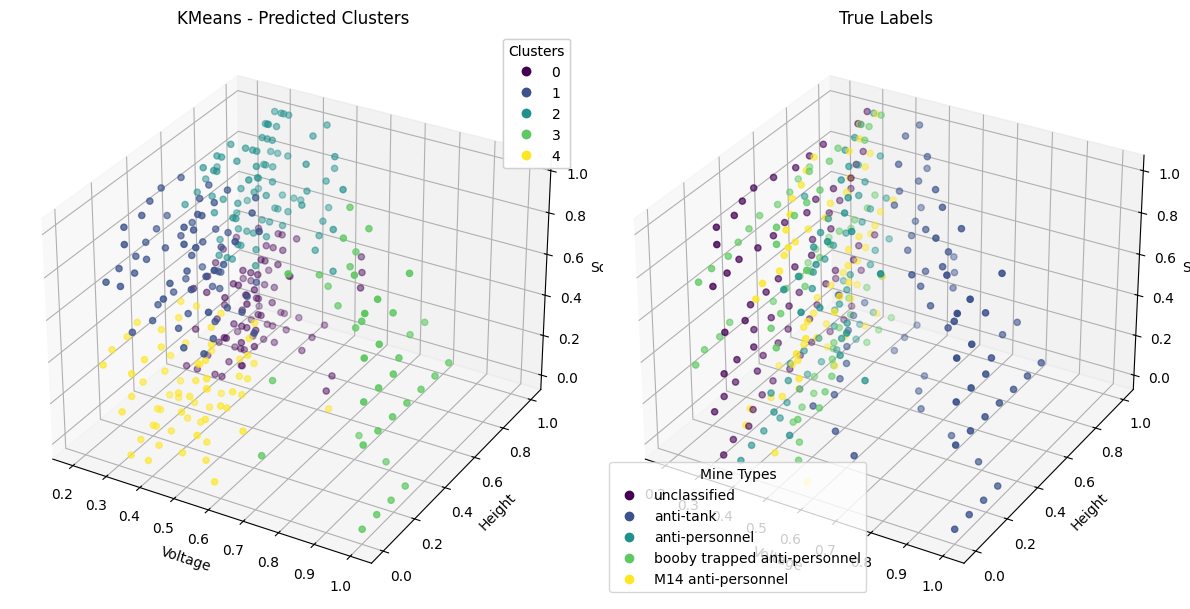

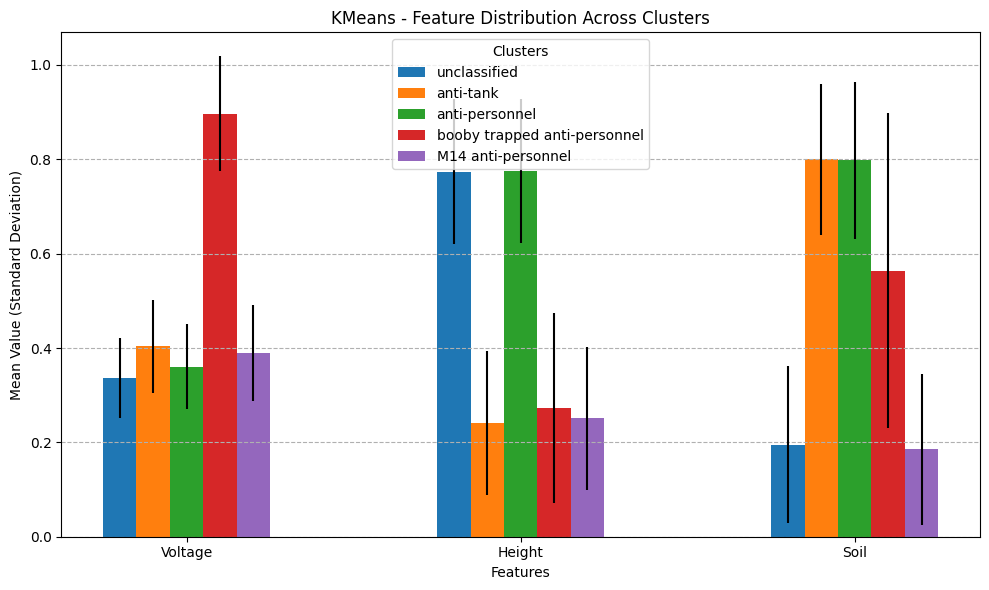

----- Agglomerative -----
Points per cluster: Counter({3: 84, 0: 80, 4: 69, 2: 65, 6: 20, 1: 14, 5: 6})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3229392541236912



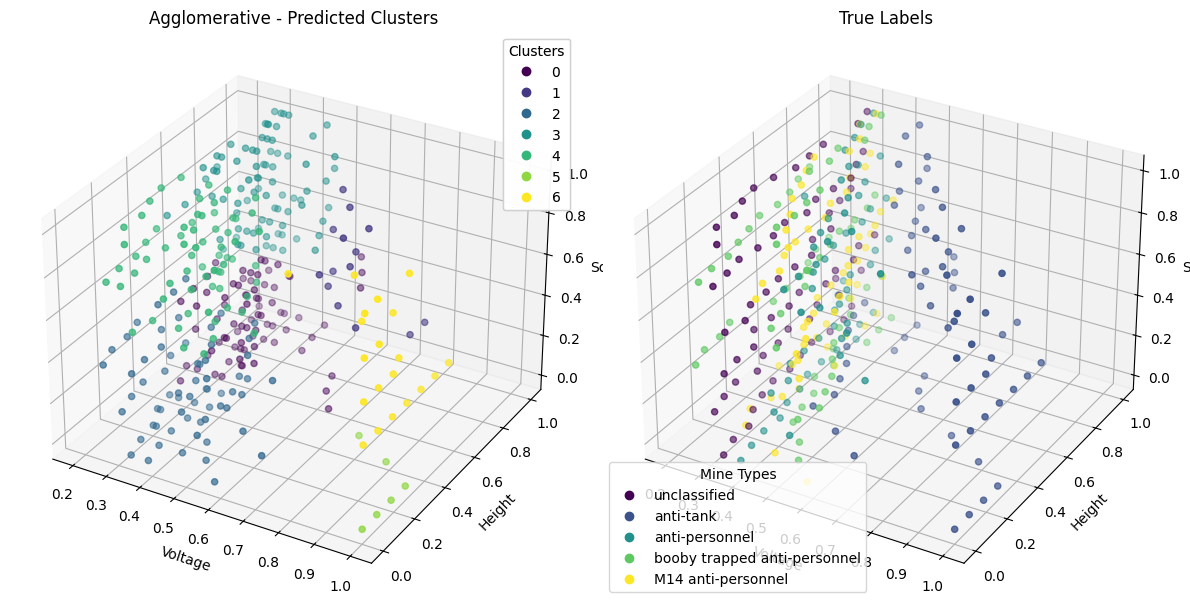

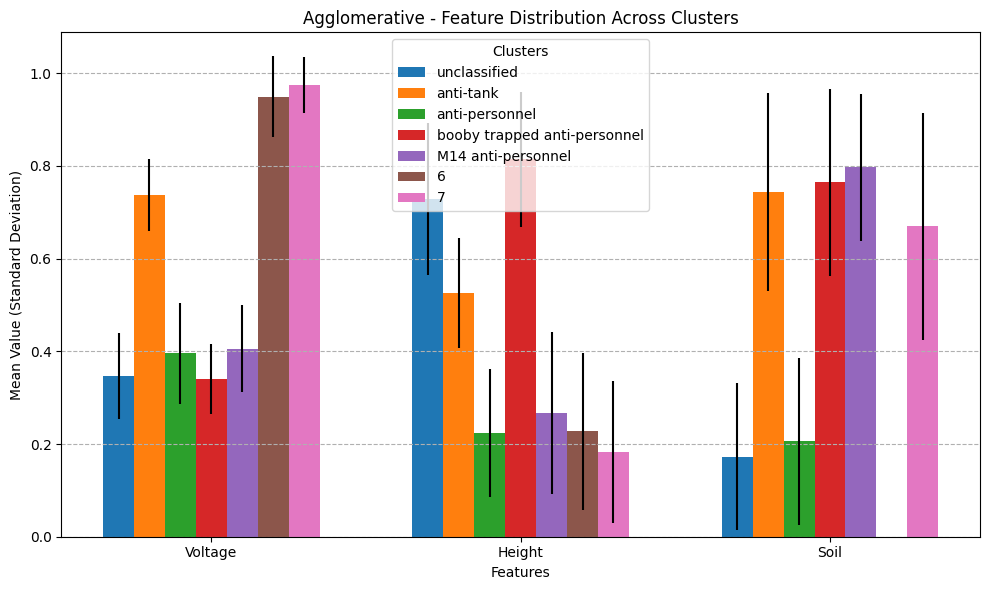

----- DBSCAN -----
Points per cluster: Counter({0: 309, 1: 18, -1: 11})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3691356680692487



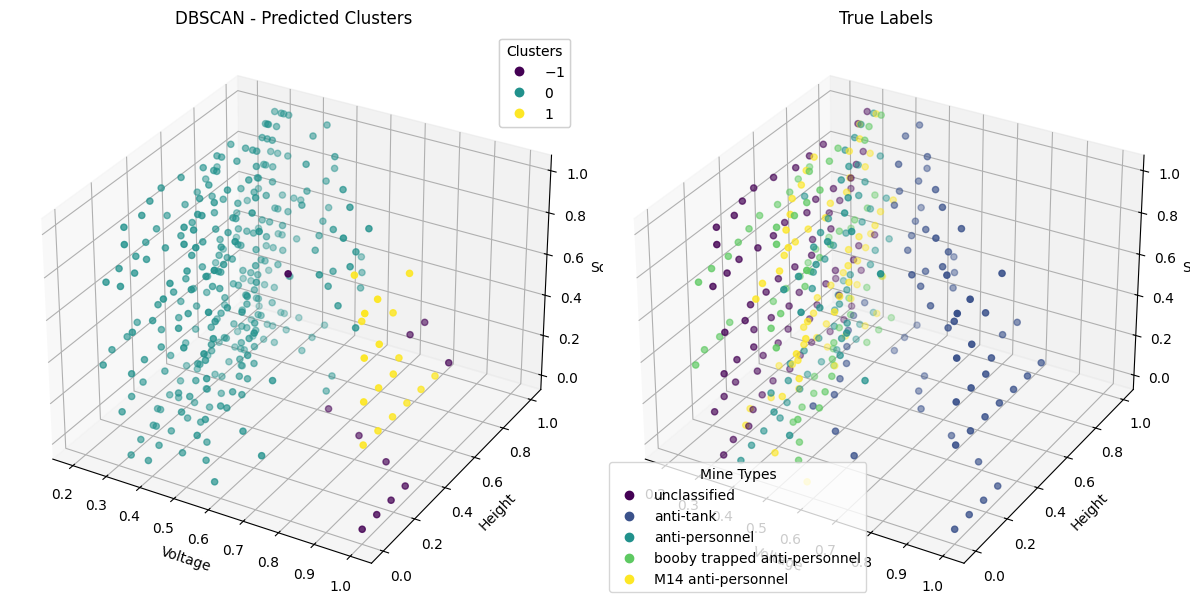

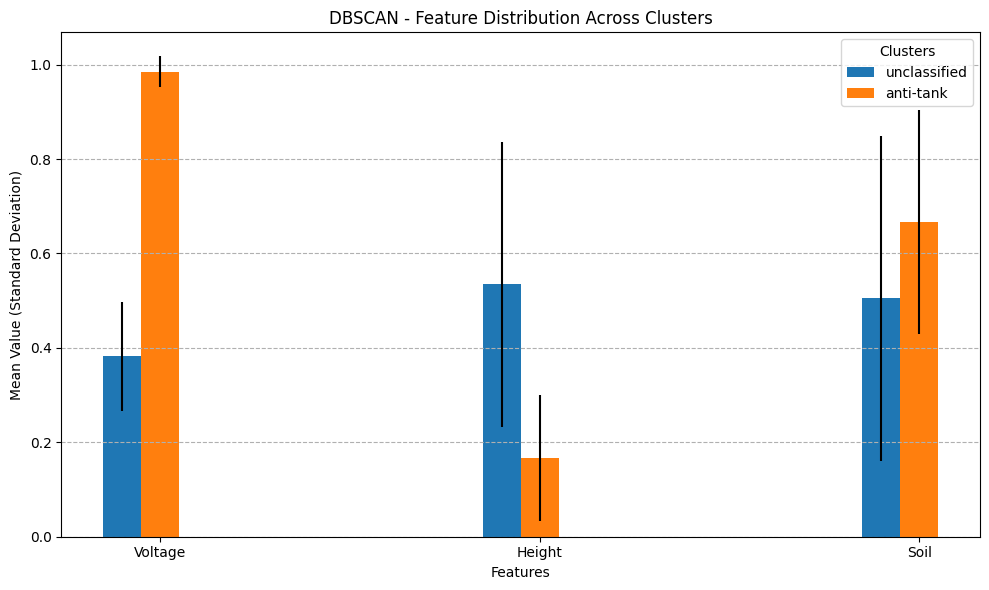

In [7]:
from mpl_toolkits.mplot3d import Axes3D

#from documentation
labels = ['unclassified','anti-tank','anti-personnel',
'booby trapped anti-personnel','M14 anti-personnel', '6', '7'] #additional buffer for aggl. clustering because n_clusters not set

for name in optimized_models:
    model = optimized_models[name]
    cluster_labels = model.fit_predict(X_scaled)

    print('-----',name,'-----')
    print('Points per cluster:',Counter(cluster_labels))
    print('True points per cluster:',Counter(y))
    print('Silhouette:',silhouette_score(X_scaled, cluster_labels))
    print()
    
    #predicted labels
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(X['V'], X['H'], X['S'], c=cluster_labels, cmap='viridis', marker='o')
    ax1.set_xlabel('Voltage')
    ax1.set_ylabel('Height')
    ax1.set_zlabel('Soil')
    ax1.set_title(f'{name} - Predicted Clusters')
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
    ax1.add_artist(legend1)
    #true labels
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(X['V'], X['H'], X['S'], c=y, cmap='viridis', marker='o')
    ax2.set_xlabel('Voltage')
    ax2.set_ylabel('Height')
    ax2.set_zlabel('Soil')
    ax2.set_title('True Labels')
    legend_elements = scatter2.legend_elements()
    ax2.legend(legend_elements[0], labels, title="Mine Types")
    plt.tight_layout()
    plt.show()

    #feature distribution
    feature_names = ['Voltage', 'Height', 'Soil']
    n_clusters = len(set(cluster_labels))

    plt.figure(figsize=(10, 6))
    cluster_means = []
    cluster_stds = []
    for i in range(n_clusters):
        cluster_data = X[cluster_labels == i]
        cluster_means.append(cluster_data.mean().values)
        cluster_stds.append(cluster_data.std().values)

    cluster_means = np.array(cluster_means)
    cluster_stds = np.array(cluster_stds)
    

    x = np.arange(len(feature_names))
    width = 0.10
    for i in range(n_clusters):
        if not np.isnan(cluster_means[i][0]):
            offset = (i - n_clusters // 2) * width
            plt.bar(x + offset, cluster_means[i], width, yerr=cluster_stds[i], label=labels[i])

    plt.xticks(x, feature_names)
    plt.xlabel('Features')
    plt.ylabel('Mean Value (Standard Deviation)')
    plt.title(f'{name} - Feature Distribution Across Clusters')
    plt.legend(title='Clusters')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

DBSCAN has the highest silhouette score, but this is due reducing the data to less clusters and overly often predicting the majority class.
Overall, none of the models perform too well. This could be either because more features are required or because there are complex, nonlinear factors at play.